In [1]:
%cd -q ~/Workspace/pose_estimation/
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

[Errno 2] No such file or directory: '/home/dawood/Workspace/pose_estimation/'


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 10.0)

import cv2
import numpy as np
import torch

In [3]:
from pycocotools.coco import COCO

from pathlib import Path

import cv2
import numpy as np
import random

from PIL import Image

from torchvision.transforms import functional as T

In [4]:
root_dir = Path('/home/dawood/Datasets/MSCOCO/')
annFile  = root_dir / 'annotations' / 'person_keypoints_val2017.json'
img_root = root_dir / 'val2017'
coco = COCO(annFile.as_posix())

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [5]:
catIds = coco.getCatIds(catNms = ['person'])
imgIds = coco.getImgIds(catIds = catIds)
imgs = coco.loadImgs(imgIds)
skeleton = coco.loadCats(catIds)[0]['skeleton']

In [24]:
def test_fn(idx, image_size=512):
    img  = imgs[idx]
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img['id'], catIds=catIds))
    img  = Image.open((img_root / img['file_name']).as_posix())

    # TODO: Try bounding box
    w, h   = img.size
    loss_mask = np.zeros((h, w), dtype=np.float)
    for ann in anns:
        if ann['num_keypoints'] == 0: continue
        loss_mask = np.maximum(loss_mask, coco.annToMask(ann))
    loss_mask = Image.fromarray(loss_mask)
    
    ow, oh = img.size
    img    = T.resize(img, image_size)
    loss_mask = T.resize(loss_mask, image_size)
    nw, nh = img.size
    sx, sy = nw/ow, nh/oh
    
    angle = random.randrange(-60, 60)
    flip  = random.random() > 0.5
    if nw > nh:
        cx1 = random.randrange(0, nw - image_size)
        cx2 = cx1 + 512
        cy1 = 0
        cy2 = 520
    elif nh > nw:
        cx1 = 0
        cx2 = 520
        cy1 = random.randrange(0, nh - image_size)
        cy2 = cy1 + 512
    else:
        cx1 = cy1 = 0
        cx2 = cy2 = 512
        
    print(img.size)
    img = T.hflip(img) if flip else img
    loss_mask = T.hflip(loss_mask) if flip else loss_mask
    
    img = T.affine(img, angle, [0, 0], 1, 0)
    loss_mask = T.affine(loss_mask, angle, [0, 0], 1, 0)
    
    print(img.size)
    cx, cy = img.size
    cx, cy = cx/2, cy/2
    M   = np.array(T._get_inverse_affine_matrix((cy, cx), angle, [0, 0], 1, 0)).reshape(2, 3) 
    
    img = np.asarray(img)
    loss_mask = np.asarray(loss_mask)
    img = img[cy1:cy2, cx1:cx2]
    loss_mask = loss_mask[cy1:cy2, cx1:cx2]
    
    h, w = img.shape[:2]
    sigma = 7. #0.01 * min(h, w)
    hm = np.zeros((17, h, w), dtype=np.float)
    jm_x = np.zeros((19, h, w), dtype=np.float)
    jm_y = np.zeros((19, h, w), dtype=np.float)
    cnts = np.zeros((h, w), dtype=np.float)
        
    print(h, w)
    base = np.indices((h, w), dtype=np.float)
    kpt_base = np.tile(base, (17, 1, 1))
    for ann in anns:
        if ann['num_keypoints'] == 0: continue
        
        keypoints = np.array(ann['keypoints']).reshape(-1, 3)
        x, y, vis = np.array(keypoints[:, 0]), np.array(keypoints[:, 1]), np.array(keypoints[:, 2])

        keypoints[:, 0] = y * sy
        keypoints[:, 1] = x * sx
        keypoints[:, 2] = 1
        
        if flip:
            keypoints[:, 1] = nw - keypoints[:, 1]
            flip_src = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
            flip_tgt = [2,1,4,3,6,5,8,7,10,9,12,11,14,13,16,15]
            keypoints[flip_src, :] = keypoints[flip_tgt, :]
            vis[flip_src] = vis[flip_tgt]
            
        keypoints = np.matmul(M, keypoints.T).T
        x, y = np.array(keypoints[:, 0]), np.array(keypoints[:, 1])
        keypoints[:, 0], keypoints[:, 1] = y, x

        keypoints[:, 0] -= cx1
        keypoints[:, 1] -= cy1
        keypoints = np.concatenate((keypoints, vis[:, np.newaxis]), axis=1)
        
        kpt_arrays = []
        for x, y, v in keypoints:
            kpt_arr = np.zeros_like(base)
            if v != 2: 
                kpt_arr[:] = np.inf
            else:
                kpt_arr[0, :, :] = y
                kpt_arr[1, :, :] = x
            kpt_arrays.append(kpt_arr)
            
        kpt_arrays = np.concatenate(kpt_arrays, axis=0)
        kpt_arrays = (kpt_arrays - kpt_base) ** 2
        for i in range(len(keypoints)):
            dst = np.exp(-np.sum(kpt_arrays[2*i:2*i+1+1], axis=0) / (2 * (sigma ** 2)))
            dst = np.maximum(hm[i], dst)
            hm[i] = dst
                   
        for i, (src, dst) in enumerate(skeleton):
            src = keypoints[src - 1]
            dst = keypoints[dst - 1]
            if src[-1] != 2 or dst[-1] != 2:
                continue
            x1, y1 = src[:2]
            x2, y2 = dst[:2]

            vx, vy = x2 - x1, y2 - y1
            norm = np.sqrt(vx**2 + vy**2)
            vx, vy = vx / norm, vy / norm
            
            vec_arr = np.zeros_like(base)
            vec_arr[0, :, :] = y1
            vec_arr[1, :, :] = x1
            diff = base - vec_arr
            dot_prod = diff[0]*vy + diff[1]*vx
            
            ort_prod = (dot_prod / (vx**2 + vy **2))
            ort_prod = (diff[0] - ort_prod * vy) * diff[0] + (diff[1] - ort_prod * vx) * diff[1]
            ort_prod = abs(ort_prod) < sigma*2
            
            dot_prod = (dot_prod <= norm) * (dot_prod > 0)
            mask = dot_prod * ort_prod

            jm_x[i][mask] += vx
            jm_y[i][mask] += vy
            cnts[mask] += 1
            
    jm_x[:, cnts > 0] /= cnts[cnts > 0]
    jm_y[:, cnts > 0] /= cnts[cnts > 0]
    
    plt.figure()
    plt.imshow(img)
    plt.imshow(hm.max(0), alpha=0.5)
    
    plt.figure()
    plt.imshow(abs(jm_x).max(0), alpha=0.5)
    plt.imshow(abs(jm_y).max(0), alpha=0.5)
    plt.imshow(img, alpha=0.5)
    
    plt.figure()
    plt.imshow(loss_mask, alpha=0.5)
    plt.imshow(img, alpha=0.5)

(682, 512)
(682, 512)
512 512


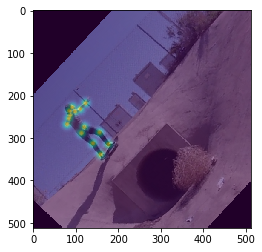

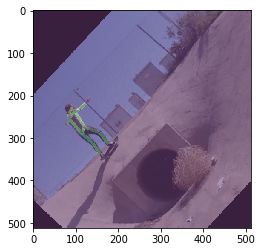

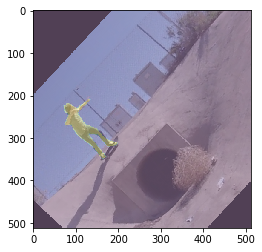

In [25]:
#idx = random.randrange(0, len(imgs))
#%lprun -f test_fn test_fn(idx)
test_fn(idx)

In [23]:
idx

2494